# Машинное обучение, DS-поток, осень 2024
## Задание ML.9

**Правила:**

* Дедлайны см. в боте. После дедлайна работы не принимаются кроме случаев наличия уважительной причины.
* Прислать нужно **ноутбук в формате `ipynb`**.
* Следите за размером файлов. **Бот не может принимать файлы весом более 20 Мб.** Если файл получается больше, заранее разделите его на несколько.
* Выполнять задание необходимо полностью самостоятельно. **При обнаружении списывания все участники списывания будут сдавать устный зачет.**
* Решения, размещенные на каких-либо интернет-ресурсах, не принимаются. Кроме того, публикация решения в открытом доступе может быть приравнена к предоставлении возможности списать.
* Для выполнения задания используйте этот ноутбук в качестве основы, ничего не удаляя из него. Можно добавлять необходимое количество ячеек.
* Комментарии к решению пишите в markdown-ячейках.
* Выполнение задания (ход решения, выводы и пр.) должно быть осуществлено на русском языке.
* Если код будет не понятен проверяющему, оценка может быть снижена.
* Никакой код из данного задания при проверке запускаться не будет. *Если код студента не выполнен, недописан и т.д., то он не оценивается.*
* В каждой задаче не забывайте делать **пояснения и выводы**.


**Правила оформления теоретических задач:**

В задании требуется вывести формулы для обратного прохода.
* Решения необходимо прислать одним из следующих способов:
  * фотографией в правильной ориентации, где все четко видно, а почерк разборчив,
    * отправив ее как файл боту вместе с ноутбуком *или*
    * вставив ее в ноутбук посредством `Edit -> Insert Image` (<font color="red">фото, вставленные ссылкой, не принимаются</font>);
  * в виде $LaTeX$ в markdown-ячейках.
* Решения не проверяются, если какое-то требование не выполнено. Особенно внимательно все проверьте в случае выбора второго пункта (вставки фото в ноутбук). <font color="red"><b>Неправильно вставленные фотографии могут не передаться при отправке.</b></font> Для проверки попробуйте переместить `ipynb` в другую папку и открыть его там.
* В решениях поясняйте, чем вы пользуетесь, хотя бы кратко. Например, если пользуетесь независимостью, то достаточно подписи вида "*X и Y незав.*"
* Решение, в котором есть только ответ, и отсутствуют вычисления, оценивается в 0 баллов

**Баллы за задание**  
    1. Простая нейронная сеть &mdash; **40 баллов**  
    2. BatchNorm &mdash; **80 баллов**  
    3. Dropout &mdash; **50 баллов**  
    4. Регуляризация весов &mdash; **30 баллов**  
    5. Затухание градиента &mdash; **40 баллов**  
    6. Выводы &mdash; **10 баллов**  
    
 Всего &mdash;   **250 баллов**.

In [157]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(palette='Set2')
sns.set_style('darkgrid')

from torchvision.datasets import FashionMNIST
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
from torch import optim
from collections import defaultdict
import numpy as np
import time
from IPython.display import clear_output
import warnings
warnings.filterwarnings("ignore")

In [158]:
# Bot check

# HW_ID: ds_ml9
# Бот проверит этот ID и предупредит, если случайно сдать что-то не то.

# Status: final
# Перед отправкой в финальном решении удали "not" в строчке выше.
# Так бот проверит, что ты отправляешь финальную версию, а не промежуточную.
# Никакие значения в этой ячейке не влияют на факт сдачи работы.


В данном задании вам предстоит проверить на практике эффективность методов, представленных на лекции на одном из базовых датасетов для нейронных сетей. Естественно, обобщать наблюдения нельзя, но некоторые тенденции вы сможете заметить.

**Совет**

Это задание будет быстрее выполнить на GPU. Чтобы не тратить много времени на GPU (важно на Google Colab), **проверяйте работоспособность кода на CPU на маленьком объеме данных**, где это возможно, а затем переходите на GPU.

In [159]:
device = torch.device('cpu')  # автоматическй выбор девайса
if torch.cuda.is_available():
    device = torch.device('cuda')
device

device(type='cuda')

### 0. Данные
Будем использовать набор данных **Fasion MNIST**. Скачаем тренировочный и тестовый наборы данных.

In [160]:
train_source = FashionMNIST('fasionmnist', download=True, train=True)
test_source = FashionMNIST('fasionmnist', download=True, train=False)

Он содержит 60 000 изображений в тренировочной части данных и 10 000 в тестовой.

In [161]:
len(train_source.data), len(test_source.data)

(60000, 10000)

In [162]:
train_source.data.shape  # ч\б картинки 28x28

torch.Size([60000, 28, 28])

В датасете содержится 10 классов одежды.

In [163]:
train_source.targets.unique()

tensor([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])

Можно посмотреть их названия.

In [164]:
train_source.classes

['T-shirt/top',
 'Trouser',
 'Pullover',
 'Dress',
 'Coat',
 'Sandal',
 'Shirt',
 'Sneaker',
 'Bag',
 'Ankle boot']

Проиллюстрируем набор данных.

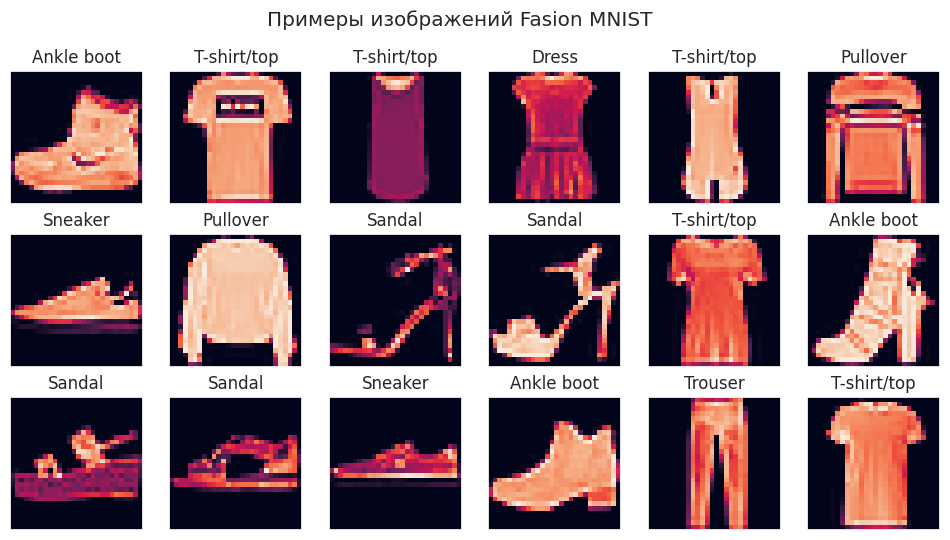

In [165]:
fig, axs = plt.subplots(3, 6, figsize=(12, 6))
for k, (image, label) in enumerate(zip(train_source.data[:18], train_source.targets[:18])):
    i, j = k // 6, k % 6
    axs[i][j].imshow(image)
    axs[i][j].grid()
    axs[i][j].set_xticks([])
    axs[i][j].set_yticks([])
    axs[i][j].set_title(train_source.classes[label])
fig.suptitle('Примеры изображений Fasion MNIST')
plt.show()

In [166]:
X_train, y_train, X_val, y_val = train_source.data, train_source.targets, test_source.data, test_source.targets  # для удобства

### 1. Простая полносвязная нейронная сеть

Сначала вспомним функцию обучения модели, которую мы уже много раз использовали.

In [167]:
def train(model, criterion, optimizer, train_loader, val_loader, num_epochs, device, checkpoint_path=None):
    """Обучение модели"""
    start_time = time.time()
    history = defaultdict(lambda: defaultdict(list))
    best_val_acc = 0.
    model.to(device)
    
    for epoch in range(num_epochs):
        train_loss, train_acc, val_loss, val_acc, train_size, val_size = 0, 0, 0, 0, 0, 0
        
        model.train()  # поведение dropout / batch_norm -> обучение
        for X_batch, y_batch in train_loader:  # на каждой эпохе - полный проход по данным
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            optimizer.zero_grad()
            logits = model(X_batch)  # обучаемся на батче (одна итерация обучения нейросети)
            loss = criterion(logits, y_batch)
            loss.backward()
            optimizer.step()
            train_loss += loss.detach() * len(y_batch)
            y_pred = torch.argmax(logits, dim=1).detach()
            train_acc += (y_pred==y_batch).sum()
            train_size += X_batch.size(0)
        train_loss = train_loss.cpu().numpy() / train_size  # считаем лоссы и точность, сохраняем в историю
        train_acc = train_acc.cpu().numpy() / train_size
        history['Лосс']['train'].append(train_loss)
        history['Акьюраси']['train'].append(train_acc)

        model.eval()  # поведение dropout / batch_norm -> тестирование
        with torch.no_grad():  # полный проход по валидации (аналогично трейну, но без градиентов)
            for X_val_batch, y_val_batch in val_loader:
                X_val_batch, y_val_batch = X_val_batch.to(device), y_val_batch.to(device)
                logits = model(X_val_batch)
                loss = criterion(logits, y_val_batch)
                val_loss += loss * len(y_batch)
                y_pred = torch.argmax(logits, dim=1)
                val_acc += (y_pred==y_val_batch).sum()
                val_size += X_val_batch.size(0)
        val_loss = val_loss.cpu().numpy() / val_size  # считаем лоссы и точность, сохраняем в историю
        val_acc = val_acc.cpu().numpy() / val_size
        history['Лосс']['val'].append(val_loss)
        history['Акьюраси']['val'].append(val_acc)

        if (checkpoint_path is not None) and (val_acc > best_val_acc):  # сохраняем лучшую модель по метрике на валидации
            torch.save({'model': model.state_dict(), 'optim': optimizer.state_dict()}, checkpoint_path)
            best_val_acc = val_acc
        clear_output()  # печатаем результаты после каждой эпохи (заменил на f-строки)
        print(f"Epoch {epoch+1} of {num_epochs}. Total time {time.time()-start_time:.3f}s")
        print(f"  training loss (in-iteration): \t{train_loss:.6f}")
        print(f"  validation loss (in-iteration): \t{val_loss:.6f}")
        print(f"  training accuracy: \t\t\t{train_acc*100:.2f} %")
        print(f"  validation accuracy: \t\t\t{val_acc*100:.2f} %")

    return history

Постройте простую полносвязную двухслойную нейронную сеть с функцией активации ReLU. Обучите ее на тренировочной части данных. Можете использовать `SimpleDataset()` из семинара. Используйте кросс-энтропию в качестве функции ошибки. Добейтесь хотя бы 0.87 accuracy на тестовой части данных.

In [168]:
model = nn.Sequential(
    nn.Linear(1*28*28, 1024),  # вход: ч\б картинки 28x28
    nn.ReLU(),
    nn.Linear(1024, 10),  # выход: 10 классов
).to(device)

In [169]:
class Dataset():
    def __init__(self, X_data, y_data):
        self.x, self.y = X_data, y_data
    def __len__(self):
        return len(self.y)
    def __getitem__(self, idx):
        return self.x[idx].float().ravel(), self.y[idx]

batch_size, num_workers, num_epochs = 500, 4, 40
train_dataset, val_dataset = Dataset(X_train, y_train), Dataset(X_val, y_val)
train_loader = DataLoader(train_dataset, batch_size, shuffle=True, num_workers=num_workers)
val_loader = DataLoader(val_dataset, batch_size, shuffle=False, num_workers=num_workers)
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=3e-4)  # lr = Karpathy const)
history = train(model, criterion, optimizer, train_loader, val_loader, num_epochs, device)

Epoch 40 of 40. Total time 56.732s
  training loss (in-iteration): 	0.130467
  validation loss (in-iteration): 	0.547097
  training accuracy: 			95.22 %
  validation accuracy: 			86.87 %


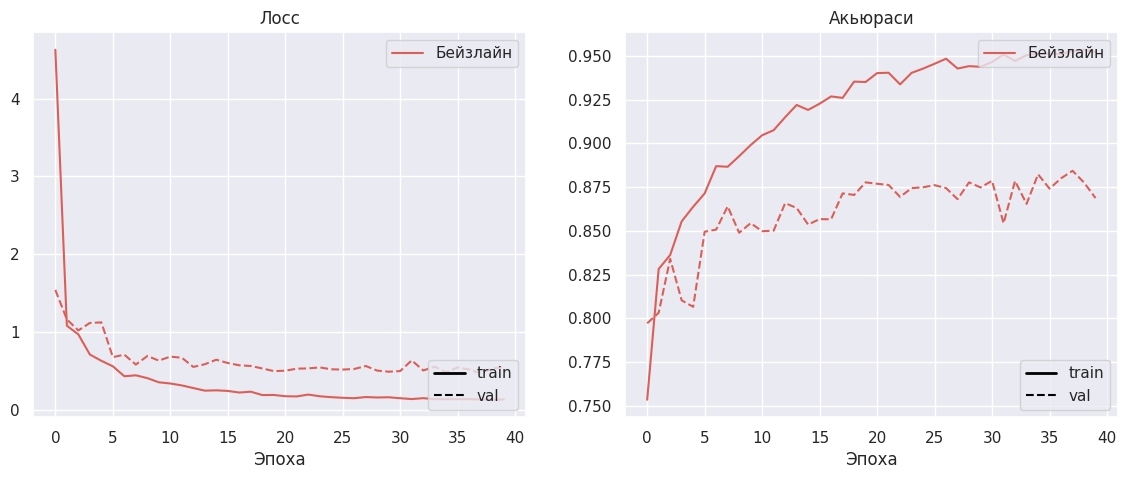

In [170]:
def plot_histories(histories, names):  
    """Отрисовка кривых обучения"""
    _, axs = plt.subplots(1, 2, figsize=(14, 5))
    epochs = np.min([len(h['Лосс']['train']) for h in histories])
    colors = sns.hls_palette(len(names)).as_hex()
    for history, name, color in zip(histories, names, colors):
        for ax, key in zip(axs, ['Лосс','Акьюраси']):
            ax.set_title(key)
            ax.plot(history[key]['train'][:epochs], label=name, c=color)
            ax.plot(history[key]['val'][:epochs], ls='--', c=color)
            ax.set_xlabel('Эпоха')
        axs[1].legend()
    dummy_lines = [axs[0].plot([], [], c='black', lw=2)[0], axs[0].plot([], [], c='black', ls='--')[0]]
    for ax in axs:
        legend = ax.legend(loc=3-i)
        ax.legend(dummy_lines, ["train", "val"], loc=4)
        ax.add_artist(legend)
    
plot_histories([history], ['Бейзлайн'])

*На валидации удалось добиться указанного качества*

Визуализируйте "вероятности" предсказанных моделью классов для нескольких изображений из теста. Для этого нужно применить SoftMax к выходам модели.

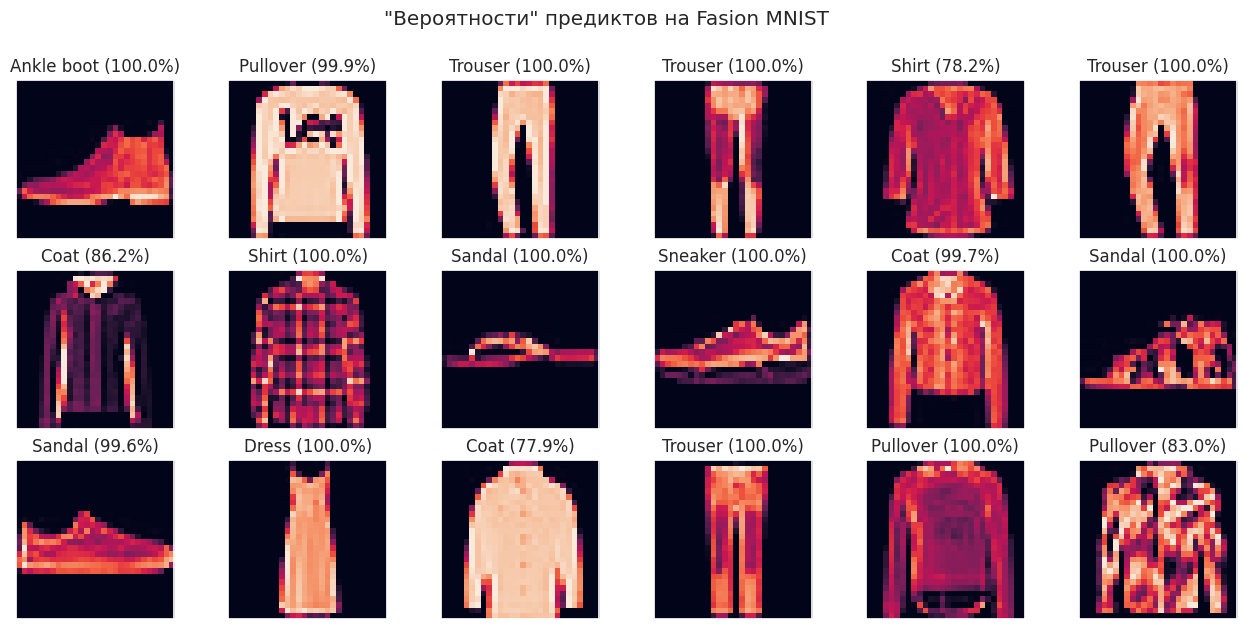

In [171]:
def plot_confs(model):
    """Визуализация предикто на тесте"""
    loader = DataLoader(val_dataset, 18, shuffle=False, num_workers=num_workers)  # для показа
    model.eval()
    with torch.no_grad():  # возьмем 1 батч удобного для показа размера
        X_val_batch, _ = [t.to(device) for t in next(iter(loader))]
        images = X_val_batch.cpu().numpy().reshape((18,28,28))
        pred = model(X_val_batch)
        y_preds = torch.argmax(pred, dim=1).cpu().numpy()
        y_confs, _ = torch.max(nn.functional.softmax(pred, dim=1), dim=1)  # софтмакс тут
        y_confs = y_confs.cpu().numpy()

    fig, axs = plt.subplots(3, 6, figsize=(16,7))
    for k, (image, y_pred, y_conf) in enumerate(zip(images, y_preds, y_confs)):
        i, j = k // 6, k % 6
        axs[i][j].imshow(image)
        axs[i][j].grid()
        axs[i][j].set_xticks([])
        axs[i][j].set_yticks([])
        axs[i][j].set_title(f'{train_source.classes[y_pred]} ({y_conf*100:.1f}%)')
    fig.suptitle('"Вероятности" предиктов на Fasion MNIST')
    plt.show()

plot_confs(model)

*Судя по отсмотренным примерам, бейзлайн-модель справляется с задачей - часто выдает правильные и уверенные предсказания. Возможно, затруднение вызывают похожие друг на друга классы (например, Coat и Pullover, которые похожи визуально и на них конфиденс пониже).*  
*В задаче этого не было, но по-хорошему, стоит детальнее изучить ошибки модели: отрисовать кейсы, на которых модель выдала высокий конфиденс, но ошиблась в классе. По итогам отсмотра, возможно, станет яснее, как улучшить перформанс модели (например, сбалансировать датасет). Плюс, наверняка помогли бы аугментации (HorizontalFlip, ShiftScaleRotate и тд)*

### 2. BatchNorm

Проверьте два варианта включения BatchNorm в архитектуру двухслойной сети: до функции активации и после нее. В итоге получается 2 модели:
```
(1) Linear -> BatchNorm -> ReLU -> Linear
(2) Linear -> ReLU -> BatchNorm -> Linear
```
Обучите обе модели. Постройте графики распределений выходов первого, второго и третьего слоя сети (т.е. всех кроме последнего) для каждой модели до обучения, в процессе обучения и после обучения. Сравните эти графики с соответствующими графиками модели без BatchNorm. В этом пункте все графики распределений лучше строить с помощью `kdeplot`.

In [172]:
models = {
    # модель без батч-нормализации
    'no_bn': nn.Sequential(nn.Linear(1*28*28, 1024), nn.ReLU(), nn.Linear(1024, 10)).to(device),
    # модели с батч-нормализацией
    'bn_relu': nn.Sequential(nn.Linear(1*28*28, 1024), nn.BatchNorm1d(1024), nn.ReLU(), nn.Linear(1024, 10)).to(device),
    'relu_bn': nn.Sequential(nn.Linear(1*28*28, 1024), nn.ReLU(), nn.BatchNorm1d(1024), nn.Linear(1024, 10)).to(device),
}

In [173]:
# def calc_outputs(model, device):  # по-моему, тут опечатка и имелся в виду не девайс, а инпут
#     '''Считает выходы модели после 1, 2 и 3 слоев. Возвращает 3 тензора.'''        
#     return <...>

layers = ['l1','l2','l3']

def calc_outputs(model, X):
    '''Считает выходы модели после 1, 2 и 3 слоев. Возвращает 3 тензора.'''  
    # в задаче не очень понятно, но видимо, нужно прогнать на всей валидации
    model.eval()
    outputs = {l:[] for l in layers}
    with torch.no_grad():
        submodels = [nn.Sequential(*list(model.children())[:c]) for c in range(1,4)]
        for X_val_batch, y_val_batch in val_loader:
            X_val_batch, y_val_batch = X_val_batch.to(device), y_val_batch.to(device)
            for l,m in zip(layers, submodels):
                outputs[l] = m(X_val_batch).flatten().cpu().numpy()
    return outputs

Будем записывать выходы модели в `outputs`.

In [174]:
outputs = {name: {l:{} for l in layers} for name in ('no_bn', 'bn_relu', 'relu_bn')}

In [175]:
train_loader = DataLoader(train_dataset, batch_size, shuffle=True, num_workers=num_workers)
val_loader = DataLoader(val_dataset, batch_size, shuffle=False, num_workers=num_workers)
criterion = nn.CrossEntropyLoss()

for model_name, model in models.items():
    optimizer = optim.AdamW(model.parameters(), lr=3e-4)
    for k,v in calc_outputs(model, X_val).items():  # выходы слоев перед обучением
        outputs[model_name][k]['init'] = v 
    train(model, criterion, optimizer, train_loader, val_loader, num_epochs=20, device=device)
    for k,v in calc_outputs(model, X_val).items():  # выходы слоев во время обучения
        outputs[model_name][k]['train'] = v
    train(model, criterion, optimizer, train_loader, val_loader, num_epochs=20, device=device)
    for k,v in calc_outputs(model, X_val).items():  # выходы слоев после обучения модели
        outputs[model_name][k]['final'] = v

Epoch 20 of 20. Total time 27.888s
  training loss (in-iteration): 	0.106219
  validation loss (in-iteration): 	0.540867
  training accuracy: 			96.21 %
  validation accuracy: 			88.65 %


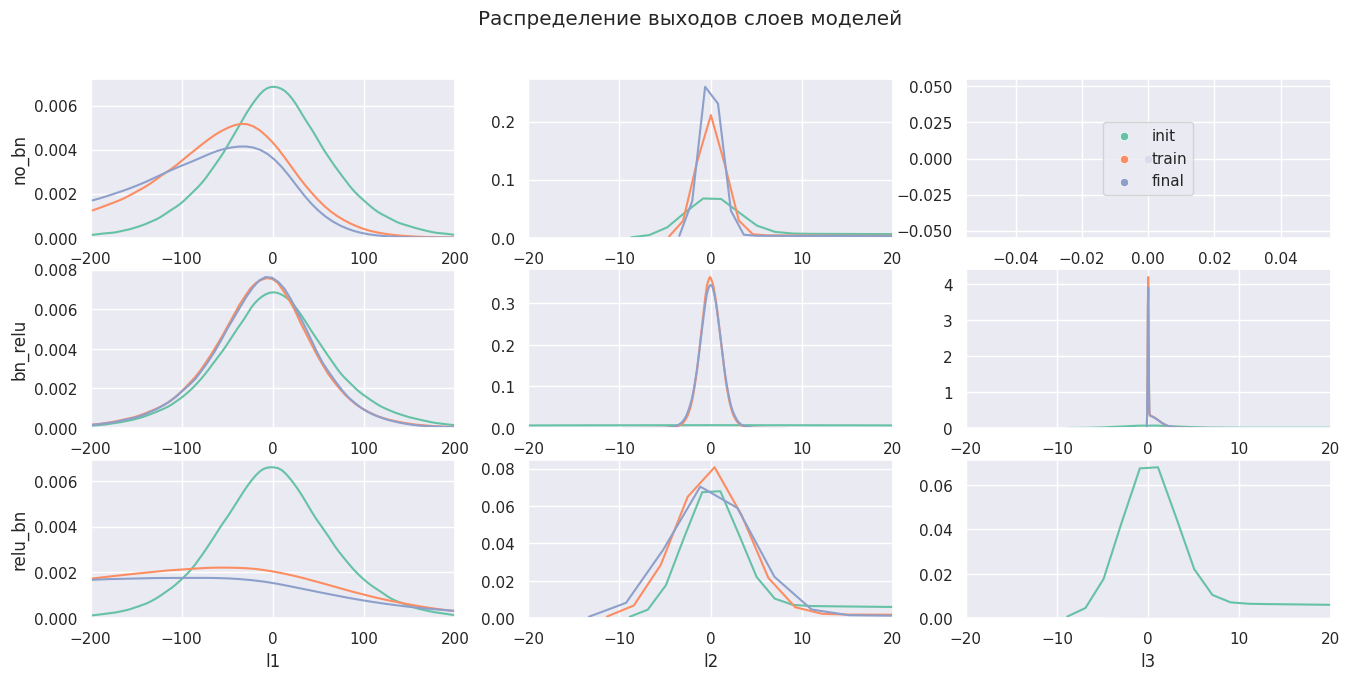

In [176]:
fig, axs = plt.subplots(3, 3, figsize=(16,7))
for i, model_name in enumerate(models.keys()):
    for j, (layer, xlim) in enumerate(zip(layers, [200,20,20])):
        
        if model_name=='no_bn' and layer=='l3':   # у no_bn на 1 слой меньше, а последний слой не интересен. Там поместим легенду
            for stage in ['init', 'train', 'final']:
                sns.scatterplot(x=[0], y=[0], label=stage, ax=axs[i][j])
            axs[i][j].legend(loc='center')
            continue

        for stage in ['init', 'train', 'final']:
            sns.kdeplot(outputs[model_name][layer][stage], ax=axs[i][j])
            axs[i][j].set_xlim((-xlim,xlim))
            axs[i][j].set_ylabel(model_name if layer=='l1' else '')
            axs[i][j].set_xlabel(layer if model_name=='relu_bn' else '')

fig.suptitle('Распределение выходов слоев моделей')
fig.show()

**Вывод:**  *насколько мне известно, в оригинальной статье по батчнорму рекоммендуют ставить Batchnorm до ReLU (т.е. ожидаемый победитель - сеть bn_relu). По графикам видно, что у bn_relu заметно ниже разброс выходов слоев, что говорит о большей стабильности модели. Это логично: батчнорм решает проблему ковариационного сдига, т.е. слои вынуждены учить закономерности в данных, а не ошибки предыдущих слоев*

Обучите оба варианта модели с BatchNorm с разными инициализациями хотя бы 3 раза. Инициализации должны отличаться только random state. Сравните качество моделей по loss и accuracy в зависимости от номера итерации.

Epoch 40 of 40. Total time 56.149s
  training loss (in-iteration): 	0.063179
  validation loss (in-iteration): 	0.478845
  training accuracy: 			97.85 %
  validation accuracy: 			88.20 %


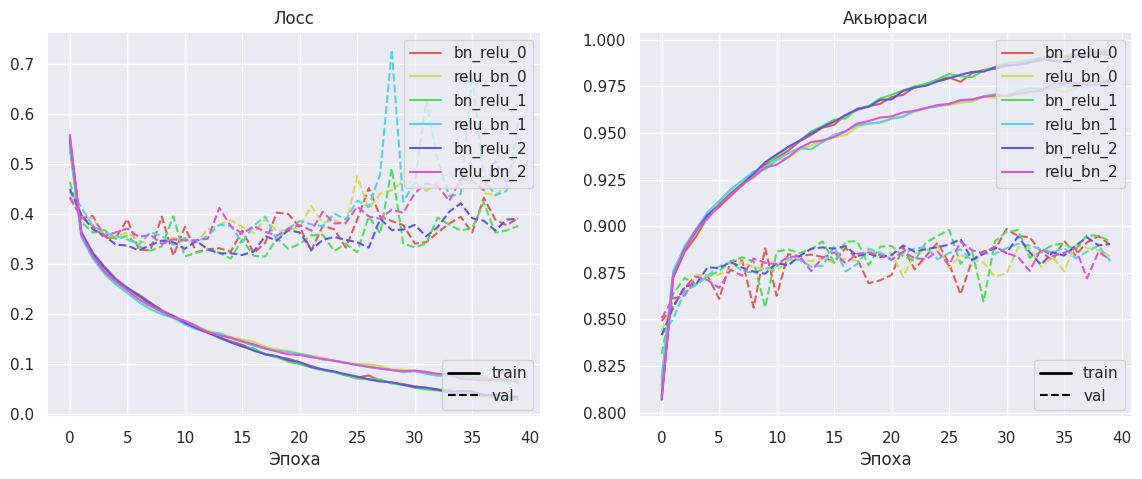

In [177]:
histories, experiments = [], []
best_model = None
for seed in range(3):
    torch.manual_seed(seed)
    models = {
        'bn_relu': nn.Sequential(nn.Linear(1*28*28, 1024), nn.BatchNorm1d(1024), nn.ReLU(), nn.Linear(1024, 10)).to(device),
        'relu_bn': nn.Sequential(nn.Linear(1*28*28, 1024), nn.ReLU(), nn.BatchNorm1d(1024), nn.Linear(1024, 10)).to(device),
    }
    for model_name, model in models.items():
        for name, param in model.named_parameters():
            try:
                param.data = nn.init.kaiming_uniform_(param.data, nonlinearity='relu')  # инит весов
            except:
                pass
        optimizer = optim.AdamW(model.parameters(), lr=3e-4)
        histories.append(train(model, criterion, optimizer, train_loader, val_loader, num_epochs=40, device=device))
        experiments.append(f'{model_name}_{seed}')
        if model_name=='bn_relu' and seed==1:  # определили постфактум
            best_model = model

plot_histories(histories, experiments)

*По графику акьюраси на валидации видно, что bn_relu справляется чуть лучше. Далее используем bn_relu_1*  
*По графику лосса видны симптомы небольшого переобучения (лосс на трейне падает, а на валидации - начал расти), но думаю, тут не страшно*

Выберите лучшую обученную модель с BatchNorm. Посмотрите на распределение выходов слоя до BatchNorm и самого BatchNorm для нескольких батчей из тестовой части данных. Согласуются ли результаты с утверждением, что BatchNorm решает проблему ковариантного сдвига для батчей?



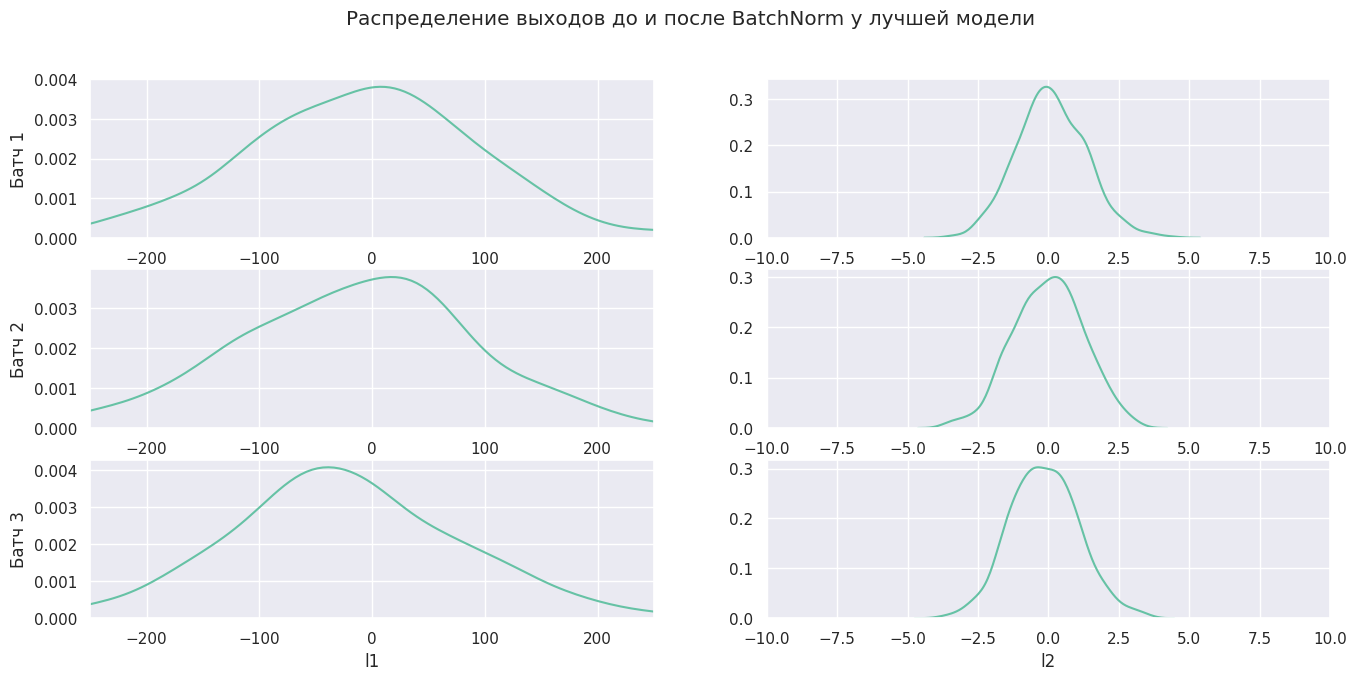

In [178]:
outputs_best = {l:{} for l in layers}
best_model.eval()

num_rows = 3
fig, axs = plt.subplots(num_rows, 2, figsize=(16,7))
with torch.no_grad():
    for k,v in calc_outputs(best_model, X_val).items():
        outputs_best[k] = v  # понадобятся только выходы 1го и 2го
        
for i in range(num_rows):  # отщипываем первые num_rows батчей
    for j, (layer, xlim) in enumerate(zip(['l1','l2'], [250,10])):
        sns.kdeplot(outputs_best[layer][i*batch_size:(i+1)*batch_size], ax=axs[i][j])
        axs[i][j].set_xlim((-xlim,xlim))
        axs[i][j].set_ylabel(f'Батч {i+1}' if layer=='l1' else '')
        axs[i][j].set_xlabel(layer if i==num_rows-1 else '')
fig.suptitle('Распределение выходов до и после BatchNorm у лучшей модели')
fig.show()

***Ответ:*** *после батчнорма выходы действительно центрируются и масштабируются. Иными словами, BatchNorm решает проблему ковариантного сдвига для батчей*

### 3. Dropout
Для начала добьемся переобучения модели. Это можно сделать, если использовать больше параметров в слое, дольше обучать или поменять параметры оптимизатора. Например, так:

In [179]:
model = nn.Sequential(nn.Linear(28 * 28, 100), nn.ReLU(), nn.Linear(100, 10))
optimizer = torch.optim.AdamW(model.parameters(), lr=2e-3)
DO_histories = []
DO_histories.append(train(model, criterion, optimizer, train_loader, val_loader, num_epochs=60, device=device))

Epoch 60 of 60. Total time 83.462s
  training loss (in-iteration): 	0.303038
  validation loss (in-iteration): 	0.475827
  training accuracy: 			88.70 %
  validation accuracy: 			85.47 %


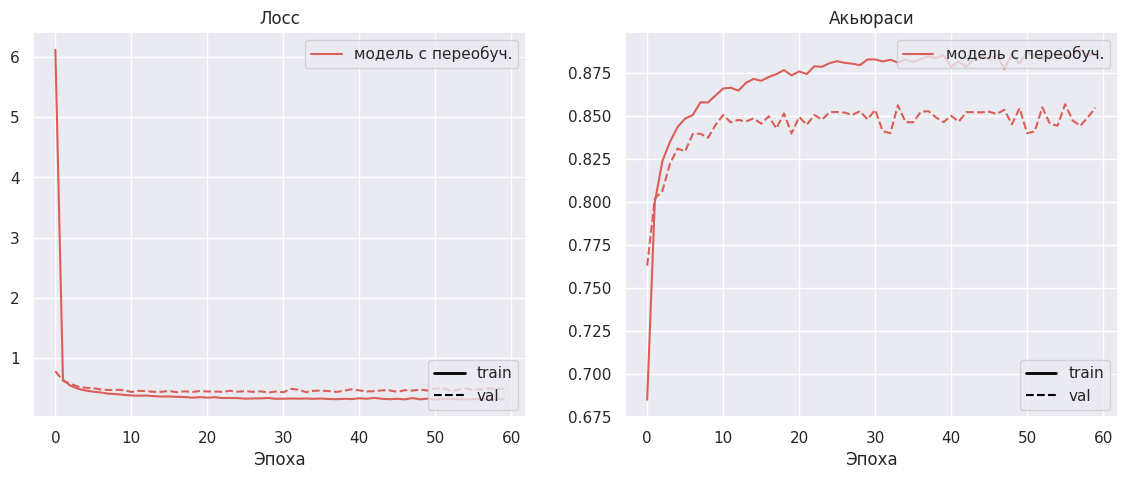

In [180]:
plot_histories(DO_histories, ['модель с переобуч.'])

*На графиках действительно есть признаки переобучения (лосс на трене продолжает немного падать, а на валидации - стал расти)*

Добавьте Dropout в модель. Сравните скорость обучения и качество моделей в зависимости от параметра $p$ в Dropout.

Epoch 60 of 60. Total time 83.249s
  training loss (in-iteration): 	1.359171
  validation loss (in-iteration): 	0.797227
  training accuracy: 			48.02 %
  validation accuracy: 			71.55 %


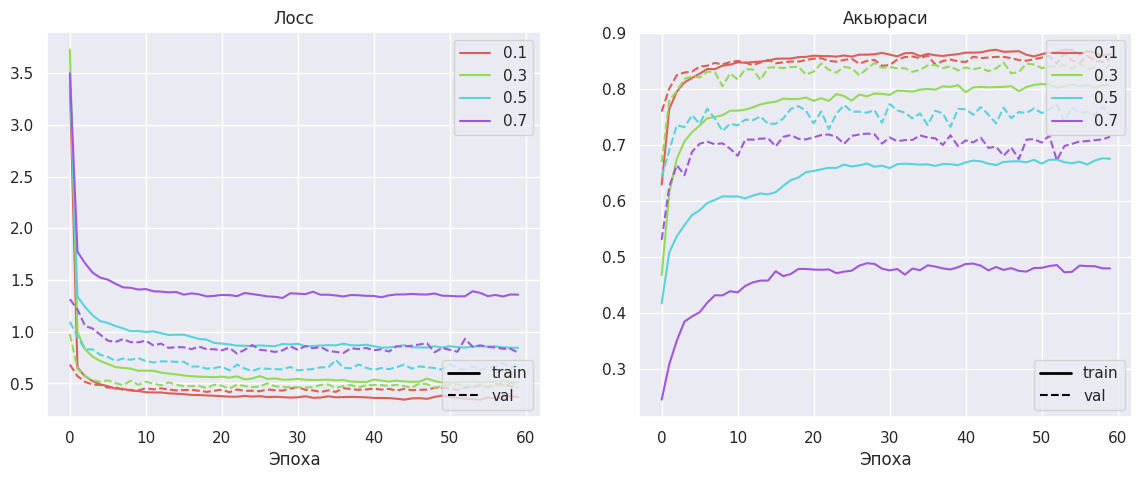

In [181]:
p_DO_histories, times, ps = [], [], [0.1, 0.3, 0.5, 0.7]
for p in ps:
    model = nn.Sequential(nn.Linear(28 * 28, 100), nn.ReLU(), nn.Dropout(p=p), nn.Linear(100, 10))  # дропаут после relu
    optimizer = torch.optim.AdamW(model.parameters(), lr=2e-3)
    start = time.time()
    p_DO_histories.append(train(model, criterion, optimizer, train_loader, val_loader, num_epochs=60, device=device))
    times.append((time.time()-start)/60)  # в пересчете на эпоху
plot_histories(p_DO_histories, ps)

*По графикам видно, что дропаут помогает, но с ним важно не переборщить. При больших значениях р качество заметно падает*

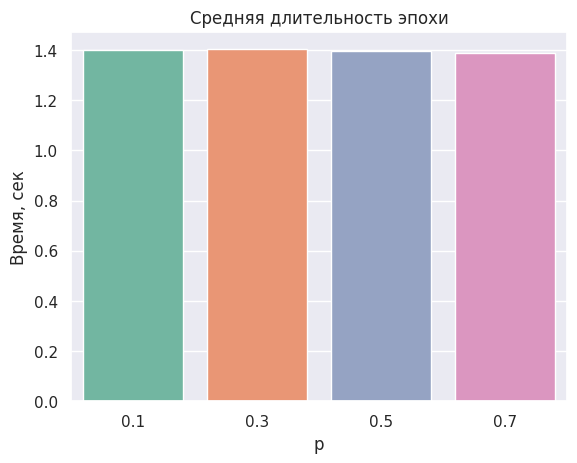

In [182]:
sns.barplot(x=ps, y=times)
plt.title('Средняя длительность эпохи')
plt.xlabel('p')
plt.ylabel('Время, сек')
plt.show()

*На масштабе рассматриваемой модели разница в скорости обучения для разных значений р пренебрежимо мала*

Измерьте, насколько переобучаются модели в каждом случае - для этого посчитайте среднюю разность лосса на валидации и трейне (со знаком) на последних 10 или 20 эпохах.

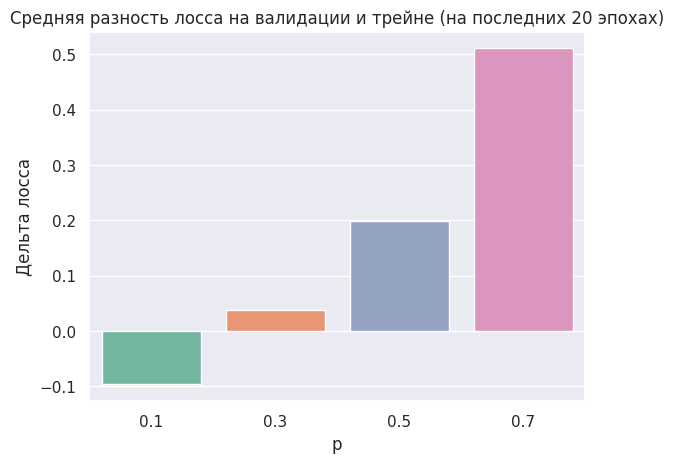

In [183]:
delta_loss = [(np.array(h['Лосс']['train']) - np.array(h['Лосс']['val']))[-20:].mean() for h in p_DO_histories]
sns.barplot(x=ps, y=delta_loss)
plt.title('Средняя разность лосса на валидации и трейне (на последних 20 эпохах)')
plt.xlabel('p')
plt.ylabel('Дельта лосса')
plt.show()

*Наименьшая дельта лосса при р=0.3*

***Вывод:*** *дропаут снижает склонность к переобучению, но параметр р важно правильно подобрать. При слишком малых или слишком больших значениях р качество упадет. На масштабе рассматриваемой модели дропаут почти не повлиял на длительность эпохи*

### 4. Регуляризация весов
Проверьте распределение весов переобученной модели в пункте 3. Попробуйте добиться такого эффекта переобучения, при котором возникают большие значения некоторых весов. Даже если не получится, нужно показать, что вы пытались ;)

In [184]:
def show_weight_distributions(model, title):
    """Рисует гистограммы весов"""
    layers = [l for l in model.children()]
    _, axs = plt.subplots(1, 4, figsize=(18, 4))
    for i, layer in enumerate(layers[::2]):  # без слоя с релу 
        w, b = layer.weight.data.ravel(), layer.bias.data.ravel()
        axs[2*i].hist(w, bins=int(np.power(len(w), 1/4))+10)
        axs[2*i].set_title(f'w{i+1}')
        # axes[2*i].set_xlim((-1,1))
        axs[2*i+1].hist(b, bins=len(b)//10+10)
        axs[2*i+1].set_title(f'b{i+1}')
        # axes[2*i+1].set_xlim((-1,1))
    plt.suptitle(title, y=0.95)
    plt.tight_layout()

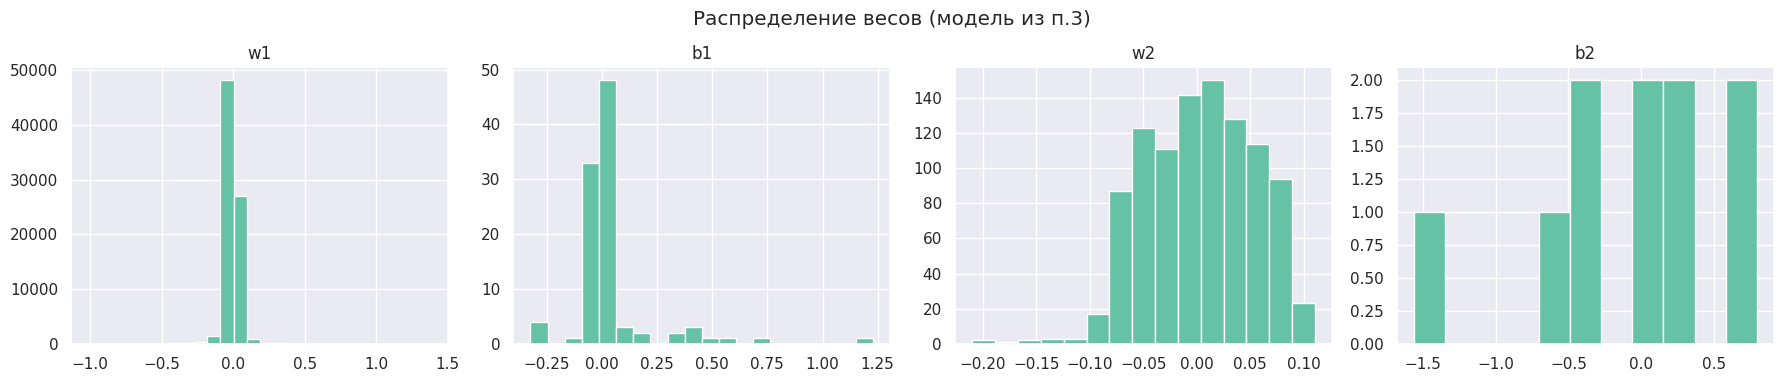

In [185]:
model = nn.Sequential(nn.Linear(28 * 28, 100), nn.ReLU(), nn.Linear(100, 10))
optimizer = torch.optim.AdamW(model.parameters(), lr=2e-3)
train(model, criterion, optimizer, train_loader, val_loader, num_epochs=60, device=device)
clear_output()
show_weight_distributions(model.cpu(), 'Распределение весов (модель из п.3)')

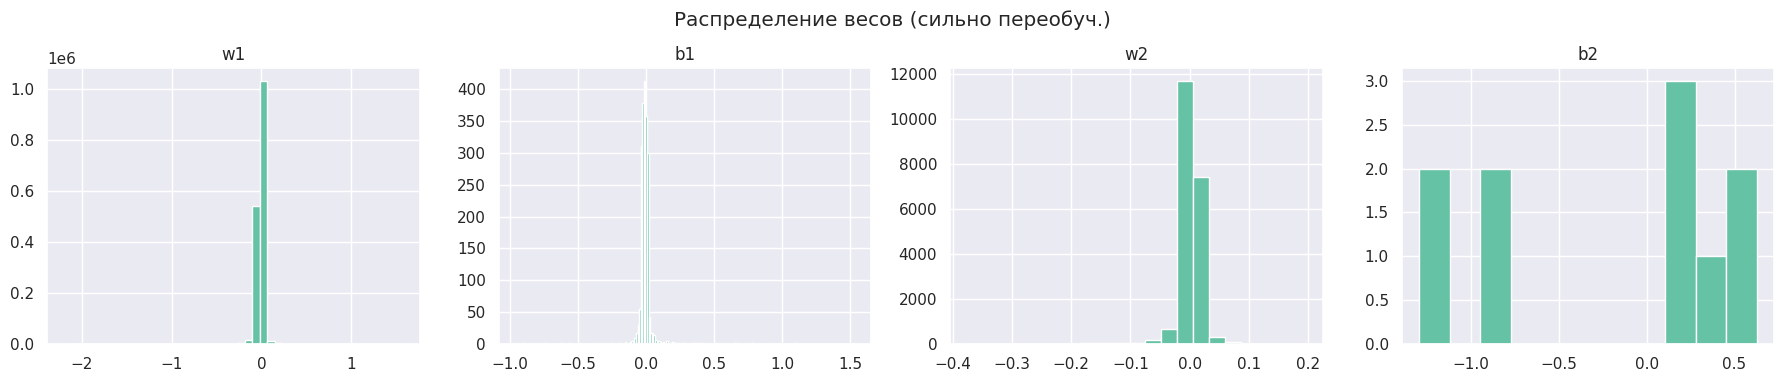

In [186]:
# сейчас сильно переобучим
model = nn.Sequential(nn.Linear(28 * 28, 2048), nn.ReLU(), nn.Linear(2048, 10))
optimizer = torch.optim.AdamW(model.parameters(), lr=2e-3)
train(model, criterion, optimizer, train_loader, val_loader, num_epochs=120, device=device)
clear_output()
show_weight_distributions(model.cpu(), 'Распределение весов (сильно переобуч.)')

Примените L2-регуляризацию при обучении модели. Для этого нужно указать коэффициент регуляризации через параметр `weight_decay` в оптимизаторе. Напоминаем, если вы хотите использовать `Adam`, то его нужно поменять на `AdamW`, так как в `Adam` регуляризация реализована не совсем корректно. Покажите, что проблема больших весов решается.

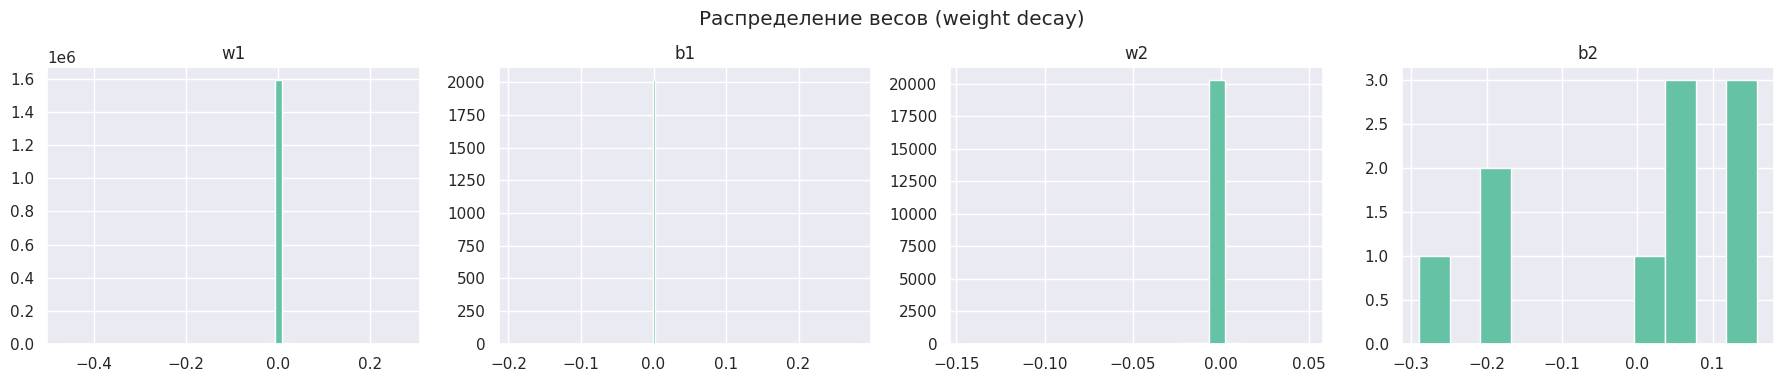

In [187]:
# то же, но добавим weight_decay
model = nn.Sequential(nn.Linear(28 * 28, 2048), nn.ReLU(), nn.Linear(2048, 10))
optimizer = torch.optim.AdamW(model.parameters(), lr=2e-3, weight_decay=0.5)
train(model, criterion, optimizer, train_loader, val_loader, num_epochs=120, device=device)
clear_output()
show_weight_distributions(model.cpu(), 'Распределение весов (weight decay)')

***Вывод:*** *weight_decay помогает регуляризовать модель, т.е. ослабить ее тенденцию к переобучению*

### 5. Затухание градиента

Продемонстрируем эффект затухания градиента. Для этого будем визуализировать долю градиентов близких к нулю на каждом слое в течение обучения. Добавим в функцию обучения подсчет доли околонулевых градиентов:

In [188]:
def train_count_zero_grads(model, criterion, optimizer, train_loader, val_loader, num_epochs, device, checkpoint_path=None):
    """Обучение модели"""
    start_time = time.time()
    history = defaultdict(lambda: defaultdict(list))
    best_val_acc = 0.
    model.to(device)

    for epoch in range(num_epochs):
        train_loss, train_acc, val_loss, val_acc, train_size, val_size = 0, 0, 0, 0, 0, 0
        
        model.train()  # поведение dropout / batch_norm -> обучение
        zero_grads = defaultdict(float) # количество околонулевых градиентов
        n_grads = defaultdict(int) # количество градиентов всего
        for X_batch, y_batch in train_loader:  # На каждой "эпохе" делаем полный проход по данным
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            optimizer.zero_grad()
            logits = model(X_batch)  # обучаемся на батче (одна итерация обучения нейросети)
            loss = criterion(logits, y_batch)
            loss.backward()
            optimizer.step()
            for name, param in model.named_parameters():  # считаем градиент околонулевым, если его модуль <1e-5
                zero_grads[name] += (torch.abs(param.grad) < 1e-5).sum().item()
                n_grads[name] += param.grad.numel()
            train_loss += loss.detach() * len(y_batch)
            y_pred = torch.argmax(logits, dim=1).detach()
            train_acc += (y_pred==y_batch).sum()
            train_size += X_batch.size(0)
        train_loss = train_loss.cpu().numpy() / train_size  # подсчитываем лоссы и точность, сохраням в "историю"
        train_acc = train_acc.cpu().numpy() / train_size
        history['Лосс']['train'].append(train_loss)
        history['Акьюраси']['train'].append(train_acc)
        for name, _ in model.named_parameters():
            mean_zero_grads = zero_grads[name] / n_grads[name]
            history['grad'][name].append(mean_zero_grads)

        model.eval()  # поведение dropout / batch_norm -> тестирование
        with torch.no_grad():  # полный проход по валидации (аналогично трейну, но без градиентов)
            for X_val_batch, y_val_batch in val_loader:
                X_val_batch, y_val_batch = X_val_batch.to(device), y_val_batch.to(device)
                logits = model(X_val_batch)
                loss = criterion(logits, y_val_batch)
                val_loss += loss * len(y_batch)
                y_pred = torch.argmax(logits, dim=1)
                val_acc += (y_pred==y_val_batch).sum()
                val_size += X_val_batch.size(0)
        val_loss = val_loss.cpu().numpy() / val_size  # считаем лоссы и точность, сохраняем в историю
        val_acc = val_acc.cpu().numpy() / val_size
        history['Лосс']['val'].append(val_loss)
        history['Акьюраси']['val'].append(val_acc)

        if (checkpoint_path is not None) and (val_acc > best_val_acc):  # сохраняем лучшую модель по метрике на валидации
            torch.save({'model': model.state_dict(), 'optim': optimizer.state_dict()}, checkpoint_path)
            best_val_acc = val_acc
        clear_output()  # печатаем результаты после каждой эпохи (заменил на f-строки)
        print(f"Epoch {epoch+1} of {num_epochs}. Total time {time.time()-start_time:.3f}s")
        print(f"  training loss (in-iteration): \t{train_loss:.6f}")
        print(f"  validation loss (in-iteration): \t{val_loss:.6f}")
        print(f"  training accuracy: \t\t\t{train_acc*100:.2f} %")
        print(f"  validation accuracy: \t\t\t{val_acc*100:.2f} %")

    return history

Epoch 40 of 40. Total time 58.377s
  training loss (in-iteration): 	0.118720
  validation loss (in-iteration): 	0.485713
  training accuracy: 			95.58 %
  validation accuracy: 			88.30 %


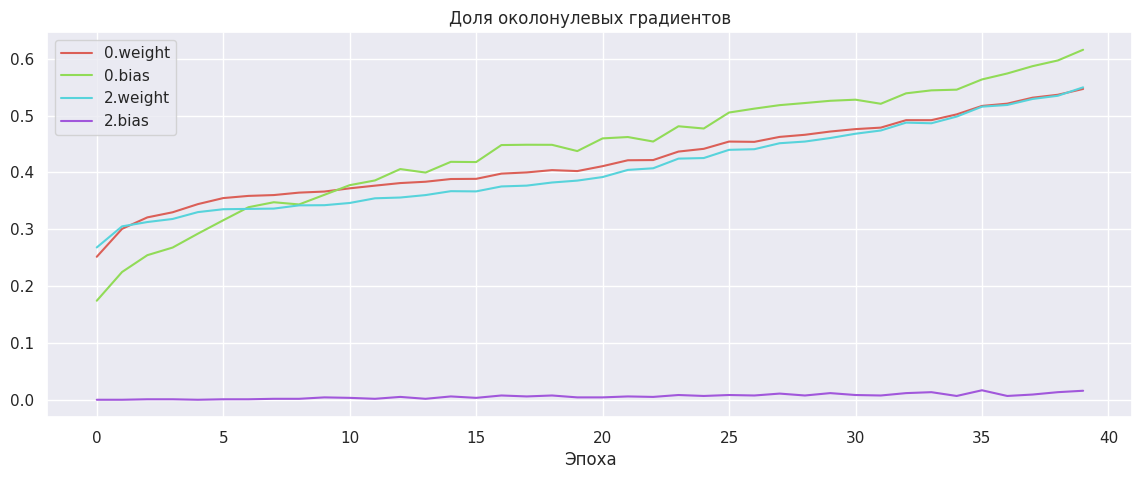

In [189]:
model = nn.Sequential(nn.Linear(1*28*28, 1024), nn.ReLU(), nn.Linear(1024, 10)).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=3e-4)
history = train_count_zero_grads(model, criterion, optimizer, train_loader, val_loader, num_epochs, device)

_, ax = plt.subplots(1, 1, figsize=(14, 5))
ax.set_title('Доля околонулевых градиентов')
colors = sns.hls_palette(len(history['grad'])).as_hex()
for color, (name, _) in zip(colors, model.named_parameters()):
    ax.plot(history['grad'][name], label=name, c=color)
ax.set_xlabel('Эпоха')
ax.legend()
plt.show()

Постройте более глубокую сеть, в качестве функций активации используйте гиперболический тангенс. Визуализируйте долю градиентов близких к нулю на каждом слое в течение обучения.

Epoch 40 of 40. Total time 60.285s
  training loss (in-iteration): 	0.431501
  validation loss (in-iteration): 	0.471385
  training accuracy: 			84.13 %
  validation accuracy: 			83.31 %


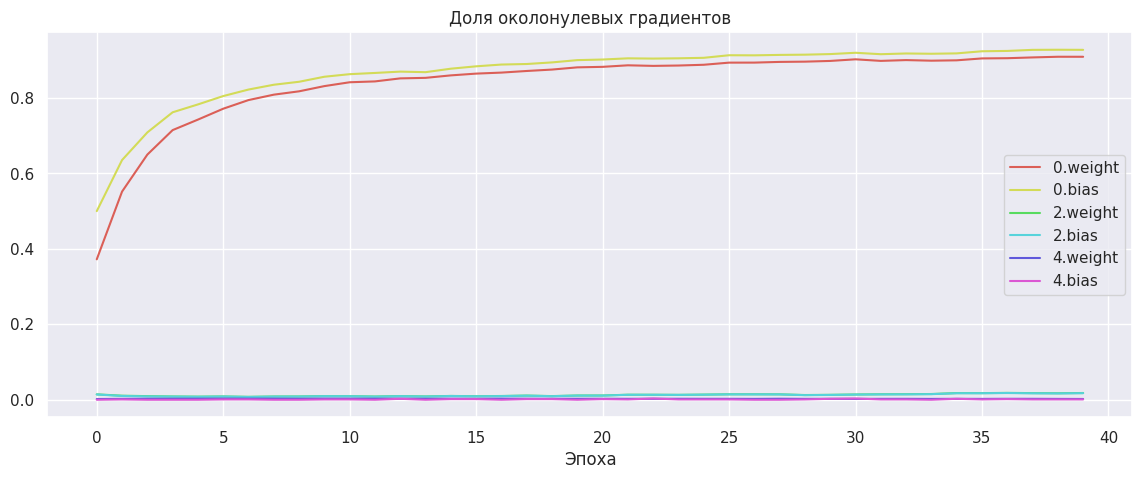

In [190]:
model = nn.Sequential(
    nn.Linear(1*28*28, 1024), 
    nn.Tanh(), 
    nn.Linear(1024, 1024),
    nn.Tanh(), 
    nn.Linear(1024, 10)
).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=3e-4)
history = train_count_zero_grads(model, criterion, optimizer, train_loader, val_loader, num_epochs, device)

_, ax = plt.subplots(1, 1, figsize=(14, 5))
ax.set_title('Доля околонулевых градиентов')
colors = sns.hls_palette(len(history['grad'])).as_hex()
for color, (name, _) in zip(colors, model.named_parameters()):
    ax.plot(history['grad'][name], label=name, c=color)
ax.set_xlabel('Эпоха')
ax.legend()
plt.show()

*Доли околонулевых градиентов выросли на 0 слое. Видна проблема затухания градиентов*

Попробуйте решить задачу затухания градиента с помощью использования функции активации LeakyReLU.

Epoch 40 of 40. Total time 61.212s
  training loss (in-iteration): 	0.088095
  validation loss (in-iteration): 	0.475199
  training accuracy: 			96.73 %
  validation accuracy: 			89.46 %


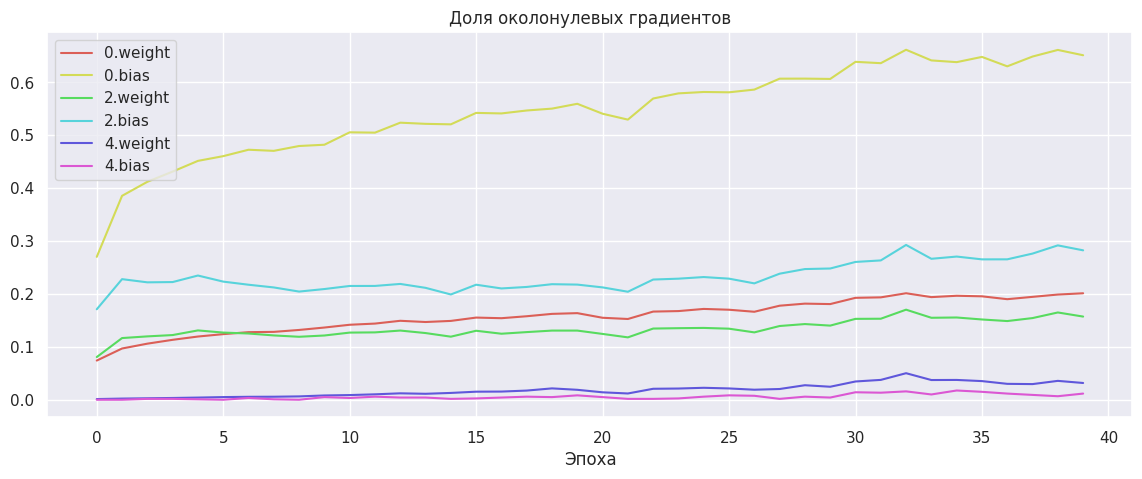

In [191]:
model = nn.Sequential(
    nn.Linear(1*28*28, 1024), 
    nn.LeakyReLU(), 
    nn.Linear(1024, 1024),
    nn.LeakyReLU(), 
    nn.Linear(1024, 10)
).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=3e-4)
history = train_count_zero_grads(model, criterion, optimizer, train_loader, val_loader, num_epochs, device)

_, ax = plt.subplots(1, 1, figsize=(14, 5))
ax.set_title('Доля околонулевых градиентов')
colors = sns.hls_palette(len(history['grad'])).as_hex()
for color, (name, _) in zip(colors, model.named_parameters()):
    ax.plot(history['grad'][name], label=name, c=color)
ax.set_xlabel('Эпоха')
ax.legend()
plt.show()

*LeakyReLU помогла немного снизить остроту проблемы затухающих градиентов*

### Выводы
Обобщите результаты проведенных экспериментов.

*В этом дз удалось познакомиться с такими приемами как BatchNorm, Dropout, weight_decay, разные функции активации. Эти приемы помогают сделать обучение нейросетей более стабильным, снизить риск переобучения и в целом - улучшить модель. Подробнее:*  

*Батчнорм решает проблему ковариационного сдига, т.е. слои вынуждены учить закономерности в данных, а не ошибки предыдущих слоев. В оригинальной статье по батчнорму рекоммендуют ставить Batchnorm до ReLU.*  
*Дропаут снижает склонность к переобучению, но параметр р важно правильно подобрать. При слишком малых или слишком больших значениях р качество упадет. На масштабе рассматриваемой модели дропаут почти не повлиял на длительность эпохи*  
*Weight_decay помогает регуляризовать модель, т.е. ослабить ее тенденцию к переобучению*  
*Функции активации отличаются по своей склонности к затуханию градиентов. Например, LeakyReLU помогла немного снизить остроту этой проблемы*  
